# Predicting loan charge-off

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.plotting import plot_lifetimes
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [5]:
sns.set_theme(style='whitegrid')

In [14]:
loan_df = pd.read_csv('loan_timing.csv')
loan_df.head(20)

,days since origination,days from origination to chargeoff
0,109,NaN
1,679,NaN
2,723,NaN
3,509,NaN
4,254,NaN
5,158,NaN
6,302,NaN
7,143,NaN
8,354,NaN
9,438,NaN


### Data exploration and cleaning

In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   days since origination              50000 non-null  int64  
 1   days from origination to chargeoff  3305 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 781.4 KB


In [8]:
loan_df.describe()

,days since origination,days from origination to chargeoff
count,50000.000000,3305.000000
mean,365.844760,214.852345
std,210.965114,165.233874
min,0.000000,0.000000
25%,183.000000,76.000000
50%,366.000000,180.000000
75%,549.000000,323.000000
max,730.000000,725.000000


In [9]:
loan_df.isnull().sum()

days since origination                    0
days from origination to chargeoff    46695
dtype: int64

#### Separation of loans that have already charged off to those that have not yet (current loans)

In [10]:
charged_off_loans = loan_df[loan_df['days from origination to chargeoff'].notna()]
charged_off_loans.shape

(3305, 2)

In [12]:
current_loans = loan_df[loan_df['days from origination to chargeoff'].isna()]
current_loans = current_loans['days since origination']
current_loans.shape

(46695,)

### Exploratory plots 

Text(0.5, 1.0, 'Histogram of days since origination for loans that have not charged off (current loans)')

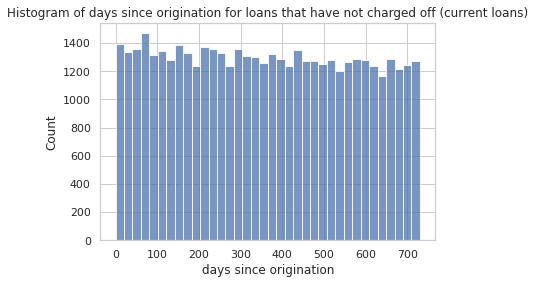

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.histplot(
    data=current_loans
)
ax.set_title('Histogram of days since origination for loans that have not charged off (current loans)')

Text(0.5, 1.0, 'Histogram of days since origination and days to charge off for loans that have charged off')

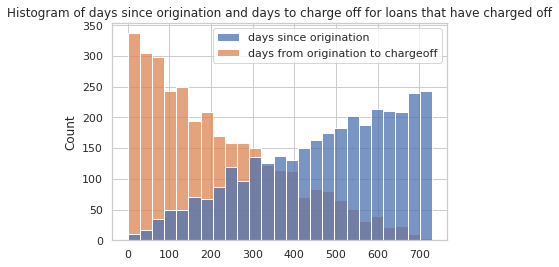

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.histplot(
    data=charged_off_loans,
    bins=25
)
ax.set_title('Histogram of days since origination and days to charge off for loans that have charged off')

Observations from the above plot:<br>
- From the `days from origination to charge-off` graph (represented in `orange`), we can see that the number of charged-off loans decreases as the `number of days from origination to charge-off` increases.
From this we can assume that newer loans are more likely to be charged off.

- From the number of days shown on the x-axis, we can see that 700 is the highest number of days. That shows us that most loans are charged off within about two years form the date of origination.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='days since origination', ylabel='days from origination to chargeoff'>

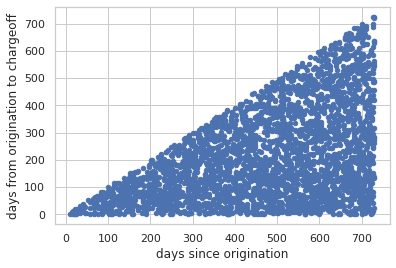

In [15]:
charged_off_loans.plot.scatter(x='days since origination', y='days from origination to chargeoff')

### Choice of approach for predicting charge-off

From the plots above, it is evident that a number of random simulations is needed on the loans dataset in order to predict charge-off.<br/>
For this, we shall use **Monte Carlo** simulations.

### Preparation for predicitons

### Monte Carlo methods

In [18]:
charged_off_loans.describe()

,days since origination,days from origination to chargeoff
count,3305.000000,3305.000000
mean,474.198790,214.852345
std,176.942232,165.233874
min,10.000000,0.000000
25%,343.000000,76.000000
50%,501.000000,180.000000
75%,625.000000,323.000000
max,730.000000,725.000000


In [19]:
avg = 1
std_dev = .1
num_of_loans = 500
num_of_simulations = 1000

In [25]:
days_to_chargeoff = np.random.normal(avg, std_dev, num_of_loans).round(2)


### Survival analysis

In [17]:
loan_df['charged off'] = loan_df['days from origination to chargeoff'].apply(lambda x: 1 if x else 0)
loan_df.fillna(0, inplace=True)
loan_df['days from origination to chargeoff'] = loan_df['days from origination to chargeoff'].astype(int)
loan_df.head(20)

,days since origination,days from origination to chargeoff,charged off
0,109,0,0
1,679,0,0
2,723,0,0
3,509,0,0
4,254,0,0
5,158,0,0
6,302,0,0
7,143,0,0
8,354,0,0
9,438,0,0


In [19]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(loan_df['days from origination to chargeoff'], loan_df['charged off'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50000 total observations, 46711 right-censored observations>

<AxesSubplot:xlabel='timeline'>

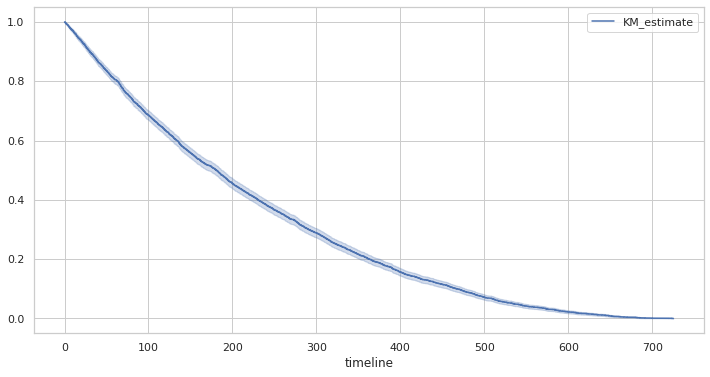

In [20]:
kmf.plot_survival_function()